# Diving into PyTorch's Automatic Backpropagation

In class, we talked quite a bit about how backpropagation theoretically works for Neural Networks (NNs). Because NNs are compositions of many layers of affine transformations and nonlinear activation functions, backpropagation uses the chain rule from calculus. We mentioned that backpropagation is as expensive as a forward model evaluation, making it an extremely powerful tool. We briefly mentioned that backpropagation is _more than just_ chainrule -- it's also the efficient data structures working behind the scenes. The purpose of this notebook is to investigate how PyTorch's automatic differentiation works.

I'll be going through [PyTorch's documentation](https://pytorch.org/docs/stable/notes/autograd.html#:~:text=Autograd%20is%20reverse%20automatic%20differentiation,roots%20are%20the%20output%20tensors.), and testing things out with easy-to-follow, analytical examples.

Let's just create a tensor $x=3$ and see what we can explore. Then, let's use this to compute a few nested functions:

$$y=x^2 \implies \frac{dy}{dx} = 2x$$
$$z=\sin(y) \implies \frac{dz}{dy} = \cos (y), \quad \frac{dz}{dx}=\frac{dz}{dy} \cdot  \frac{dy}{dx} = \cos(x^2) \cdot 2x$$

We can externally verify that for this $x$ value, $y=9$, and $z=0.41211848524$, and that $\frac{dy}{dx} = 6$, $\frac{dz}{dy} = -0.91113026188$, $\frac{dz}{dy}=-5.46678157131$

In [149]:
import torch
import numpy as np

x = torch.tensor(3.0,requires_grad=True)
print(x)
print(x.grad_fn)
y = torch.pow(x,2)
print(y)
dydx = y.grad_fn
print(dydx)
z = torch.sin(y)
dzdy = z.grad_fn
print(z)
print(dzdy)

dydx_analytical = lambda x: 2.0*x
dzdy_analytical = lambda y: torch.cos(y)
dzdx_analytical = lambda x: dydx_analytical(x) * dzdy_analytical(x**2)

tensor(3., requires_grad=True)
None
tensor(9., grad_fn=<PowBackward0>)
tensor(0.4121, grad_fn=<SinBackward>)


In [150]:
print(dydx._saved_self)
print(dzdy._saved_self)
print(dydx._saved_exponent)

tensor(3., requires_grad=True)
tensor(9., grad_fn=<PowBackward0>)
2


We also have these weird `PowBackward0` and `CosBackward` objects. From PyTorch documentation: 

_When computing the forwards pass, autograd simultaneously performs the requested computations and builds up a graph representing the function that computes the gradient (the .grad_fn attribute of each torch.Tensor is an entry point into this graph). When the forwards pass is completed, we evaluate this graph in the backwards pass to compute the gradients._

The previous section was the forward pass, so the graph has been built.

We can also access the inputs to get $y$ (which was $x$) and to get $z$ (which was $y$). There's also a `saved_exponent`, but only for the power operation, likely because this operation is parameterized by whatever power we actually choose (in this case 2).

Let's explore them more by passing some random variables.

In [151]:
# z.backward(retain_graph=True)

pi = torch.tensor(np.pi)
u = torch.tensor(1.0)
v = torch.sqrt(pi)/3
w = torch.tensor(4.0)
rand_vars = [u,v,w]
for rv in rand_vars:
    print(f'PyTorch backward function:\t{dydx(rv)}\nAnalytical derivative: \t\t{dydx_analytical(x)*rv}')
    print(f'PyTorch backward function:\t{dzdy(rv)}\nAnalytical derivative: \t\t{dzdy_analytical(x**2)*rv}')



PyTorch backward function:	6.0
Analytical derivative: 		6.0
PyTorch backward function:	-0.9111302495002747
Analytical derivative: 		-0.9111302495002747
PyTorch backward function:	3.544908046722412
Analytical derivative: 		3.544908046722412
PyTorch backward function:	-0.5383121371269226
Analytical derivative: 		-0.5383121371269226
PyTorch backward function:	24.0
Analytical derivative: 		24.0
PyTorch backward function:	-3.6445209980010986
Analytical derivative: 		-3.6445209980010986


Through lots of trial-and-error, and some digging around on [Stack Exchange](https://stackoverflow.com/questions/43451125/pytorch-what-are-the-gradient-arguments), we've uncovered what these functions actually do. The `grad_fn` of `y` is the following:

$$ g(u) = \frac{dy}{dx} \bigg \vert _{x} \cdot u = (2 \cdot 3) \cdot u$$

and the `grad_fn` of `z` is the following:

$$ h(u) = \frac{dz}{dy} \bigg \vert _{y} \cdot u = (\cos(3^2))\cdot u$$

At first, this seems trivial, but this would be helpful for dealing with tensors (the math kind, not just the PyTorch datatype). It also makes chain rule more straight forward, as shown by this next example.

In [152]:
dzdx_val = dzdy(dydx(u))
print(dzdx_val)

tensor(-5.4668, grad_fn=<MulBackward0>)


Thus, we see that this structure makes sense for building in chain rule. The tensor structure will likely be helpful for evaluating gradients with respect to each sample in an entire bash, or for doing the same process over all the nodes in a NN layer.

In [153]:
xs = torch.tensor([3.0,2.0],requires_grad=True)
y = torch.pow(xs,2)
z = torch.sin(y)
u = torch.tensor([[1.0]]*5)

dz_of_dy = z.grad_fn(y.grad_fn(u))
print(dz_of_dy)
print(y.grad_fn(z.grad_fn(u)) == dz_of_dy)

tensor([[-5.4668, -2.6146],
        [-5.4668, -2.6146],
        [-5.4668, -2.6146],
        [-5.4668, -2.6146],
        [-5.4668, -2.6146]], grad_fn=<MulBackward0>)
tensor([[True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True]])


## PyTorch's Backward

So we've looked into `grad_fn` a little, and alluded to the graph structure relating to composition of functions. In deep learning, the main purpose of the gradient functionality is to update the parameter to minimize a loss function. From [PyTorch Forums](https://discuss.pytorch.org/t/what-does-the-backward-function-do/9944) _`loss.backward()` computes `dloss/dx` for every parameter `x` which has `requires_grad=True` _. This means that `backward` is like our call `z.grad_fn(y.grad_fn(u))` in the previous block. We will keep exploring down this route.

I'm going to create my own example of linear regression. For least squares linear regression, we have the following system:

$$ \underbrace{ \begin{bmatrix} 
1 & x_0 \\
1 & x_1 \\
1 & x_2 \\
\vdots & \vdots \\
1 & x_n \\
\end{bmatrix}}_A

\underbrace{ \begin{bmatrix} \theta_0 \\ \theta_1 \end{bmatrix}}_\Theta
= \underbrace{\begin{bmatrix}
y_0 \\
y_1 \\
y_2 \\
\vdots \\
y_n \\ \end{bmatrix}}_b
$$

We may, or may not have a solution for this equality problem. However, we can try and get our model to be as "close" as possible to the data. For least squares, we define "close" by the square of the $\mathcal{L}^2$ or Euclidean norm. In this case, we can find the best model parameters by the Normal equations:

$$ \Theta_{optimal} = \arg \min_\Theta  || A \Theta - b ||^2_2 = (A^T A)^{-1} A^T b$$

We will have $\Theta_{optimal}$ as the true solution, but we will pretend we don't know it, because usually we don't have an analytical solution for the minimum.

NameError: name 'gcf' is not defined

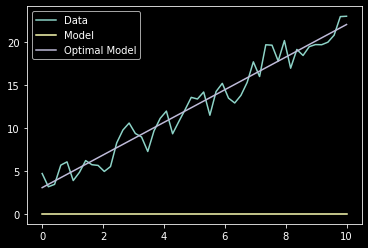

In [170]:
import matplotlib.pyplot as plt

# Generate some simple data
x = torch.tensor(np.linspace(0,10),dtype=torch.float32)
y = 5*torch.rand_like(x) + 2*x

# Create a matrix system.
A = torch.vstack((torch.ones_like(x),x)).T
b = torch.reshape(y,[len(y),1])

# Create a linear model and use it to calculate predictions
Theta = torch.tensor([[0.0],[0.0]],requires_grad=True)
y_pred = torch.matmul(A,Theta)

# By solving the analytical normal equations, we find the mean-squred optimal theta
Theta_optimal = torch.linalg.solve(torch.matmul(A.T,A),torch.matmul(A.T,b))
y_optimal_pred = torch.matmul(A,Theta_optimal)

with torch.no_grad():
    plt.plot(x.numpy(),y.numpy())
    plt.plot(x.numpy(),y_pred.numpy())
    plt.plot(x.numpy(),y_optimal_pred.numpy())
    plt.legend(('Data','Model','Optimal Model'))

Now let's use PyTorch's optimization to find a good $\Theta$. Here, we need to wrap `Theta` in block paranthesis because PyTorch expects an iterable. For instance, the iterable would contain different weights tensors corresponding to different layers.

In [155]:
optimizer = torch.optim.SGD([Theta], lr=0.001)
# This is only needed if we run cells in a weird order. At this point, the grads should be None / zero
if Theta.grad is not None:
    print(f'Setting Theta.grad to None...')
    Theta.grad = None

# Define our loss function as what we will want to minimize (given above)
def loss_fcn(A,Theta,b):
    return torch.pow(torch.norm(torch.matmul(A,Theta)-b),2)

print(f'Theta.grad: {Theta.grad}')
print(f'Current Theta: {Theta}')
print(f'Optimal Theta: {Theta_optimal}')

# Compute the loss for our current Theta
print('Computing Loss...')
loss = loss_fcn(A,Theta,b)
print(f'Theta.grad: {Theta.grad}')
print(f'Current Theta: {Theta}')

# Propagate gradients
print(f'Running loss backward...')
loss.backward()
print(f'Theta.grad: {Theta.grad}')
print(f'Current Theta: {Theta}')

# Update parameters
optimizer.step()
print(f'Theta.grad: {Theta.grad}')
print(f'New Theta: {Theta}')

Theta.grad: None
Current Theta: tensor([[0.],
        [0.]], requires_grad=True)
Optimal Theta: tensor([[3.0202],
        [1.8987]])
Computing Loss...
Theta.grad: None
Current Theta: tensor([[0.],
        [0.]], requires_grad=True)
Running loss backward...
Theta.grad: tensor([[-1251.3896],
        [-7903.8169]])
Current Theta: tensor([[0.],
        [0.]], requires_grad=True)
Theta.grad: tensor([[-1251.3896],
        [-7903.8169]])
New Theta: tensor([[1.2514],
        [7.9038]], requires_grad=True)


So we see that computing the loss does not itself propagate the gradients. Instead, running `loss.backward` propagates the gradient, saved as the parameter's `grad` attribute.

Then, running `optimizer.step` updates the parameter values, based on this gradient information (and also based on the optimizer itself).

In [156]:
try:
    del optimizer
    # This may cause an error if optimizer is already deleted
except:
    print('Could not find optimizer')

# This would be similar to calling optimizer.zero_grad()
Theta.grad = None
print(f'Theta.grad: {Theta.grad}')

print('Computing Loss...')
loss = loss_fcn(A,Theta,b)

# Propagate gradients again once, without optimizer existing
print(f'Running loss backward...')
loss.backward()
print(f'Theta.grad: {Theta.grad}')

try:
    # Propagate gradients again
    print(f'Running loss backward...')
    loss.backward()
    print(f'Theta.grad: {Theta.grad}')
except:
    print('Error: Trying to backward through the graph a second time')

Theta.grad: None
Computing Loss...
Running loss backward...
Theta.grad: tensor([[ 2825.6580],
        [19336.7715]])
Running loss backward...
Error: Trying to backward through the graph a second time


We get an error when we try to run `loss.backward()`, and the error explains that the computational graph was already freed. To elaborate more, whenever we run a forward pass (`loss = loss_fcn(A,Theta,b)`), we _create_ the computational graph. Then, for the backward run, we use this computational graph to compute the gradients. There are two reasons that we want to make the computational graph to keep for later:
1. So we know which function came before our current function. This is like knowing the order of function compositions so that we may apply chain rule.
2. So we know what the function _values_ of the previous functions were. This is like in the previous example where $dy/dz$ is evaluated at $y$. Rather than computing $y$ by squaring $x$ again, we just have $y$ stored from the forward pass, where we already did this on our way to get $z$.

In [157]:
# Zero Gradients
Theta.grad = None
print(f'Theta.grad: {Theta.grad}')

print('Computing Loss...')
loss = loss_fcn(A,Theta,b)

# Propagate gradients again once, without optimizer existing
print(f'Running loss backward...')
loss.backward(retain_graph=True)
print(f'Theta.grad: {Theta.grad}')

# Propagate gradients again once, without optimizer existing
print(f'Running loss backward...')
loss.backward()
print(f'Theta.grad: {Theta.grad}')

Theta.grad: None
Computing Loss...
Running loss backward...
Theta.grad: tensor([[ 2825.6580],
        [19336.7715]])
Running loss backward...
Theta.grad: tensor([[ 5651.3159],
        [38673.5430]])


We see that we can use the `retain_graph=True` argument to prevent the computational graph of `loss` from being freed during `loss.backward()`. We can then call `loss.backward()` again, and we see that the gradients are added. Thus means that if we have two loss components, $l(\Theta) = l_1(\Theta) + l_2(\Theta)$, we could compute $dl/d\Theta$ by either of the following:
```
l = l1 + l2
l.backward()
```
or
```
l1.backward()
l2.backward()
```

Here's another example, and a final sanity check. Let's create `loss_simple` $= \theta_1 + \theta_2$. Then, when we call `loss_simple.backward()`, we illustrate the idea above, and we can verify that the gradient being stored lines up with what we analytically expect. We expect for `Theta.grad` to increase by $1$ for each of its elements.

In [158]:
loss_simple = torch.sum(Theta)
prev_grad = torch.clone(Theta.grad)
print(f'Theta.grad: {Theta.grad}')

loss_simple.backward()
print(f'Theta.grad: {Theta.grad}')
print(f'dloss_simple/dTheta: {Theta.grad - prev_grad}')

Theta.grad: tensor([[ 5651.3159],
        [38673.5430]])
Theta.grad: tensor([[ 5652.3159],
        [38674.5430]])
dloss_simple/dTheta: tensor([[1.],
        [1.]])


#### Tada!

## Using PyTorch's Optimizers

Now, let's return to our problem of finding $$ \Theta_{optimal} = \arg \min_\Theta  || A \Theta - b ||^2_2 = (A^T A)^{-1} A^T b$$ by using iterative optimization steps. We've seen this code before. We'll now just iterate the following steps:
1. Compute the loss for our current $\Theta$. Save this to look at our training error.
2. Use `loss.backward` to compute the gradients with respect to $\Theta$, stored as `Theta.grad`
3. Use `optimizer.step` which uses the information from `Theta.grad` to update $\Theta$
4. Call `optimizer.zero_grad()` to set `Theta.grad` to zero for the next iteration.

We'll also keep a history of $\Theta$ for learning purposes, but there's not much reason to do this in practice.

In [281]:
Theta = torch.tensor([[0.0],[0.0]],requires_grad=True)
optimizer = torch.optim.SGD([Theta], lr=0.0001)

n_params = len(Theta)
N_iterations = 10000
Theta_history = torch.zeros((N_iterations+1,n_params))
Theta_history[0,:] = Theta[:,0].detach()
losses = []

for i in range(N_iterations):
    optimizer.zero_grad()
    loss = loss_fcn(A,Theta,b)
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    Theta_history[i+1,:] = Theta[:,0].detach()

print(Theta_history)
print(Theta_optimal)

tensor([[0.0000, 0.0000],
        [0.1254, 0.7915],
        [0.2100, 1.3102],
        ...,
        [3.0566, 1.8966],
        [3.0566, 1.8966],
        [3.0566, 1.8966]])
tensor([[3.0567],
        [1.8966]])


Now let's look at our loss as a function of the epochs. We expect for this to decrease and become constant. Because we're using a simple linear model, there's no possibility to overfit our data, so we don't need to worry about comparing against some test error. We can also experiment with the learning rate and see what happens. If the learning rate is increased to $0.0004$, we see that we do not get `NaN`s, but we do increase the loss function for a few iterations. If we increase the learning rate beyond that, we get `NaN`s by the final iterations.

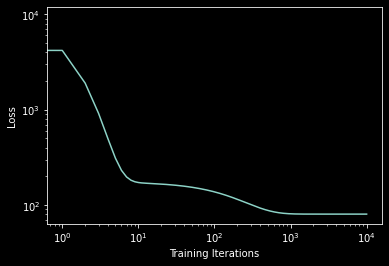

In [295]:
def plot_losses(losses):
    plt.figure()
    plt.plot(losses)
    plt.xlabel('Training Iterations')
    plt.ylabel('Loss')
    plt.xscale('log')
    plt.yscale('log')

plot_losses(losses)

Let's also visualize how $\Theta$ changes over the iterations, or how it moves across the loss surface.

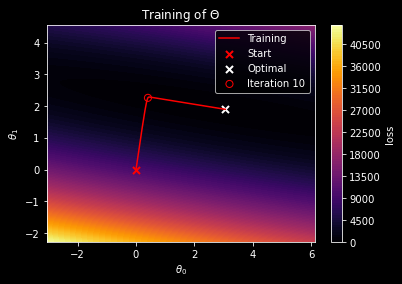

In [294]:
from cProfile import label
from textwrap import fill

n_grid = 100
expansion_factor = 4

# This is our loss function if A and b are constant.
l = lambda Th : loss_fcn(A,Th,b)

def make_loss_visualization(n_grid,expansion_factor,Theta_history,l,Theta_optimal):

    theta_0_bnds = torch.linspace(torch.min(Theta_history[:,0]).item(),torch.max(Theta_history[:,0]).item(),n_grid)
    theta_1_bnds = torch.linspace(torch.min(Theta_history[:,1]).item(),torch.max(Theta_history[:,1]).item(),n_grid)

    # Expand the bounds so we can see edges a little more
    theta_0_bnds = theta_0_bnds - expansion_factor*(theta_0_bnds - torch.mean(theta_0_bnds))
    theta_1_bnds = theta_1_bnds - expansion_factor*(theta_1_bnds - torch.mean(theta_1_bnds))

    theta_grid = torch.meshgrid(theta_0_bnds,theta_1_bnds)

    loss_grid = torch.zeros(n_grid,n_grid)
    for i in range(n_grid):
        for j in range(n_grid):
            theta_pt = torch.tensor([[theta_grid[0][i][j]],[theta_grid[1][i][j]]])
            loss_grid[i][j] = l(theta_pt)
            # loss_grid[i][j] = loss_fcn(A,theta_pt,b)

    plt.figure()
    plt.contourf(theta_grid[0],theta_grid[1],loss_grid,levels=100,cmap='inferno')
    cb = plt.colorbar()
    cb.set_label('loss')
    plt.scatter(Theta_history[0,0],Theta_history[0,1],s=50,marker='x',color='r',linewidth=2,label='Start')
    plt.plot(Theta_history[:,0],Theta_history[:,1],'-r',label='Training')
    plt.scatter(Theta_optimal[0],Theta_optimal[1],s=50,marker='x',color='w',linewidth=2,label='Optimal')
    plt.legend()
    plt.title(r'Training of $\Theta$')
    plt.xlabel(r'$\theta_0$')
    plt.ylabel(r'$\theta_1$')


# Use the function to make this visualization
make_loss_visualization(n_grid,expansion_factor,Theta_history,l,Theta_optimal)
plt.scatter(Theta_history[10,0],Theta_history[10,1],s=50,marker='o',color='r',label='Iteration 10',facecolor='none')
plt.legend()

In the above, we see a few interesting features:
1. Within 10 iterations, we have already moved to a very nice loss location ($~200$), and the rest of the time is spent making slight improvements beyond this.
2. We do not move directly toward $\Theta_{optimal}$, but instead make two perpendicular movements.
3. In this case, we do in fact reach $\Theta_{optimal}$.

Let's do this once more with a different optimizer.

In [333]:
def do_LBFGS_training(lr):
    Theta = torch.tensor([[0.0],[0.0]],requires_grad=True)
    optimizer = torch.optim.LBFGS([Theta], lr=lr)

    n_params = len(Theta)
    N_iterations = 2000
    Theta_history = torch.zeros((N_iterations+1,n_params))
    Theta_history[0,:] = Theta[:,0].detach()
    losses = []

    def closure():
        optimizer.zero_grad()
        loss = l(Theta)
        losses.append(loss.item())
        loss.backward()
        return loss

    for i in range(N_iterations):
        closure()
        optimizer.step(closure=closure)
        Theta_history[i+1,:] = Theta[:,0].detach()

    # print(Theta_history)
    # print(Theta_optimal)

    plot_losses(losses)
    make_loss_visualization(n_grid,expansion_factor,Theta_history,l,Theta_optimal)
    plt.title(f'LBFGS, Learning Rate: {lr}')

The above function will receive a learning rate and perform LBFGS optimization, with vizualizations.

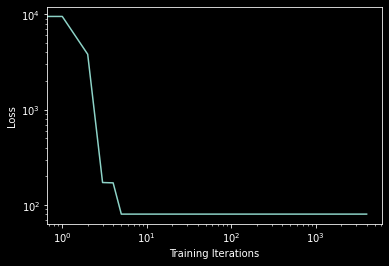

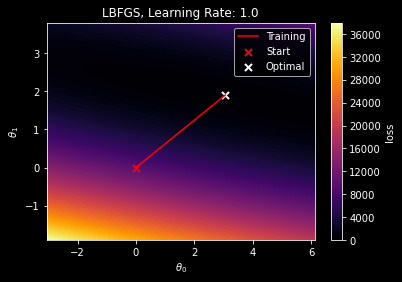

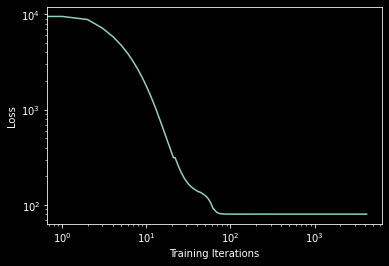

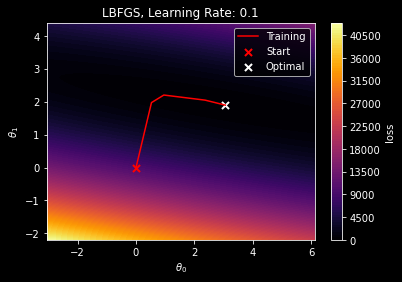

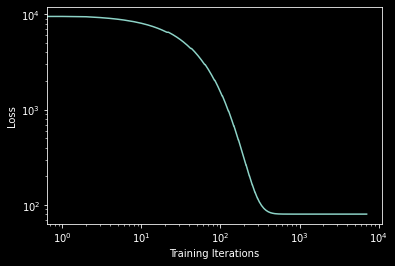

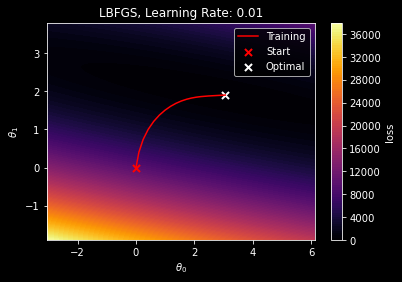

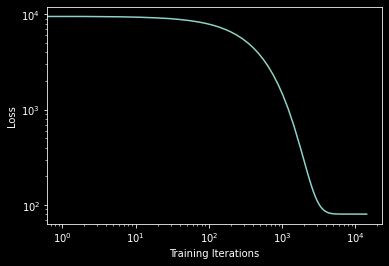

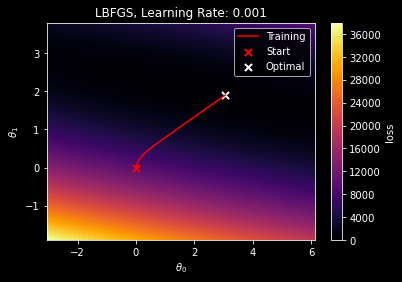

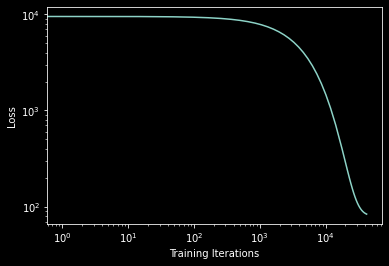

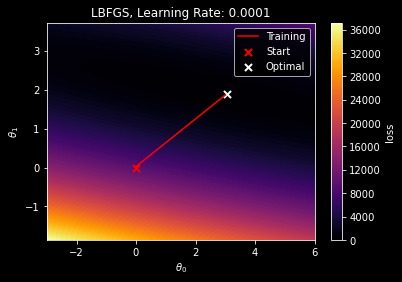

In [334]:
do_LBFGS_training(1.0)
do_LBFGS_training(0.1)
do_LBFGS_training(0.01)
do_LBFGS_training(0.001)
do_LBFGS_training(0.0001)

More observations:
1. LBFGS takes much longer per iteration than Stochastic Gradient Descent. This is because LBFGS is a Quasi-Newton methods, which are more accurate but require more memory and potentially more computation.
2. With `lr=1`, we reach the solution after just a few iterations. This is because our objective is quadratic in $\Theta$, and a second order optimizer (Newton's Method) solves quadratic minimization exactly. This method is not quite as accurate as Newton's Method, but it's much closer than SGD.
3. Changing the learning rate gives different paths for the losses on the loss surface. We start off with a straight line, which then curves, but then returns to a straight line. This differs from SGD where changing the learning rate really only changed how quickly we jumped along the two perpendicular lines. The worst curve here (the circular arc for `lr=0.01`) takes a more direct path than the best SGD curve.

## Conclusion

In conclusion, we explored PyTorch's autograd mechanics, including `grad_fn` for individual derivative operations, `backward` for loss functions to propagate many derivatives like chain rule, and optimizers which update parameters based on storing gradients in the `.grad` attribute of parameters.